<a href="https://colab.research.google.com/github/decile-team/submodlib/blob/master/tutorials/Quantitative_Analysis_on_ImageNette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

The image collection used for this application is a subset of [Imagenette dataset](https://github.com/fastai/imagenette). Specifically, it contains 40 images from each of the following categories: cassette player, church, garbage truck, gas pump, golf ball, parachute, dog

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Sample images from the dataset

Checking  /content/drive/MyDrive/demo-image-collection-labeled/truck
Checking  /content/drive/MyDrive/demo-image-collection-labeled/golf
Checking  /content/drive/MyDrive/demo-image-collection-labeled/parachute
Checking  /content/drive/MyDrive/demo-image-collection-labeled/cassette
Checking  /content/drive/MyDrive/demo-image-collection-labeled/church
Checking  /content/drive/MyDrive/demo-image-collection-labeled/dog
Checking  /content/drive/MyDrive/demo-image-collection-labeled/gas


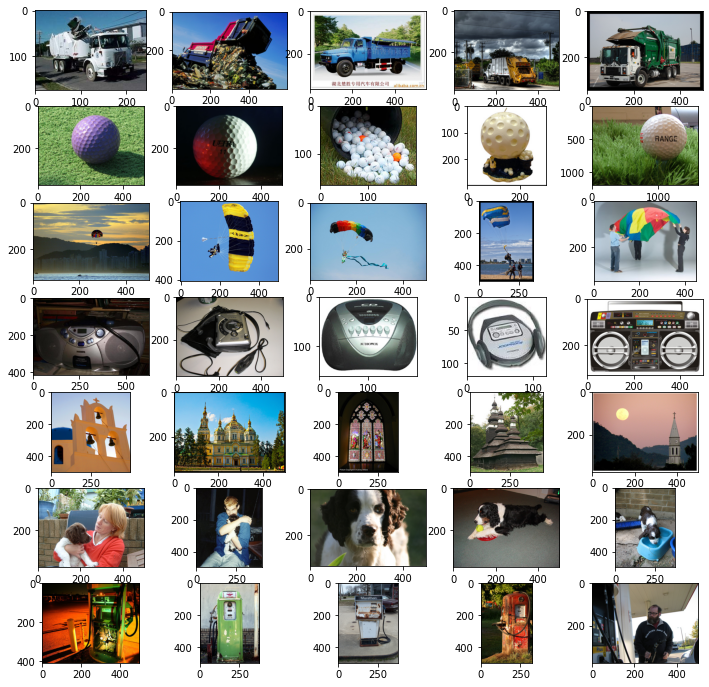

In [81]:
import os
import random
import matplotlib.pyplot as plt
import cv2

random.seed(2)
path = '/content/drive/MyDrive/demo-image-collection-labeled'
folders = os.listdir(path)
row = 0
index = 1
plt.figure(figsize=(12,12))
for folder in folders:
  folder_path = os.path.join(path, folder)
  if folder_path.endswith("hdf5") or folder_path.endswith("queries") or folder_path.endswith("checkpoints") or folder_path.endswith("results"):
    continue
  print("Checking ", folder_path)
  images = os.listdir(folder_path)
  some_images = random.sample(images, 5)
  for image in some_images:
    image_path = os.path.join(folder_path, image)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 load images as BGR, convert it to RGB
    plt.subplot(7, 5, row*5+index)
    plt.imshow(img)
    index += 1
    if index == 6:
      row += 1
      index = 1

# Feature Extraction

We take pre-extracted VGG features from Image Collection Summarization example. Specifically, 4096 dimensional features from the second last layer of vgg11_bn model from torchvision.models.

# Kernel Computation

In [10]:
!pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ submodlib

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple/
     |████████████████████████████████| 82 kB 714 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for submodlib: filename=submodlib-1.1.4-cp37-cp37m-linux_x86_64.whl size=497827 sha256=a69b0f2fe3e419251599867e3267a85f5d01d1a3584c20f20d809069b4b3d292
  Stored in directory: /root/.cache/pip/wheels/8f/37/34/ae58243a976a0b8b03670bda6b5d6134386d2389ff472b1b49
Successfully built submodlib


In [11]:
from submodlib.helper import create_kernel
features_file = "features_labels_vgg.hdf5"
hf = h5py.File(os.path.join(path, features_file), 'r')
data = hf["features"][:]
K_dense = create_kernel(data, "cosine")
with h5py.File(os.path.join(path, "kernel_cosine_vgg.hdf5"), 'w') as kf:
    kf.create_dataset("kernel",  data=K_dense)
print("Done. Shape of kernel = ", K_dense.shape)
hf.close()

Done. Shape of kernel =  (280, 280)


# Sanity check of prepared dataset with labels

Features:  (280, 4096)
Images:  (280,)
Labels:  (280,)


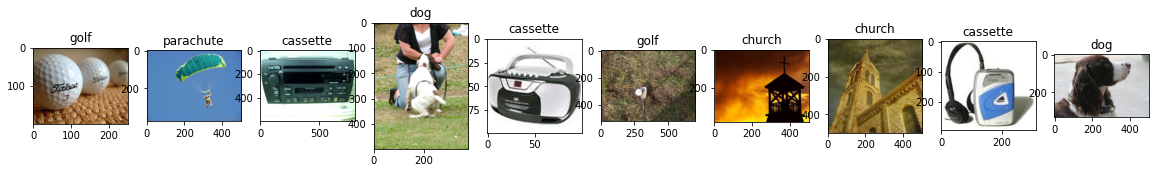

In [82]:
# Sanity check for prepared dataset with labels

import matplotlib.pyplot as plt
import random
import h5py
import os
from PIL import Image

path = '/content/drive/MyDrive/demo-image-collection-labeled'
classes_id = {0:"truck", 1:"parachute", 2:"golf", 3:"gas", 4:"dog", 5:"church", 6:"cassette"}
id_classes = {"truck":0, "parachute":1, "golf":2, "gas":3, "dog":4, "church":5, "cassette":6}
hf = h5py.File(os.path.join(path, "features_labels_vgg.hdf5"), 'r')
features = hf["features"][:]
print("Features: ", features.shape)
images = hf["images"][:]
print("Images: ", images.shape)
images = [x.decode("UTF-8") for x in images]
labels = hf["labels"][:]
print("Labels: ", labels.shape)
index = 1
plt.figure(figsize=(20,4))
ids = random.sample(range(280), 10)
for i in ids:
  image_path = os.path.join(path, classes_id[labels[i]], images[i])
  img = Image.open(image_path).convert('RGB')
  plt.subplot(1,10,index)
  plt.title(classes_id[labels[i]])
  plt.imshow(img)
  index+=1

# Quantitative Analysis

In [83]:
from submodlib import GraphCutFunction
from submodlib import FacilityLocationFunction
from submodlib import DisparitySumFunction
from submodlib import DisparityMinFunction
from submodlib import LogDeterminantFunction
from submodlib import FacilityLocationMutualInformationFunction
from submodlib import FacilityLocationVariantMutualInformationFunction
from submodlib import ConcaveOverModularFunction
from submodlib_cpp import ConcaveOverModular
from submodlib import GraphCutMutualInformationFunction
from submodlib import LogDeterminantMutualInformationFunction
from submodlib import GraphCutConditionalGainFunction
from submodlib import FacilityLocationConditionalGainFunction
from submodlib import LogDeterminantConditionalGainFunction
from submodlib import FacilityLocationConditionalMutualInformationFunction
from submodlib import LogDeterminantConditionalMutualInformationFunction

def create_object(mode, function, n, param, queryData, magnificationEta, queryDiversityLambda):
  groundData = features
  if mode == "generic":
    if function == "GC":
      return GraphCutFunction(n=n, mode="dense", lambdaVal=param, data=groundData, metric="cosine")
    elif function == "FL":
      return FacilityLocationFunction(n=n, data=groundData, mode="dense", metric="cosine")
    elif function == "DSUM":
      return DisparitySumFunction(n=n, data=groundData, mode="dense", metric="cosine")
    elif function == "DMIN":
      return DisparityMinFunction(n=n, data=groundData, mode="dense", metric="cosine")
    elif function == "LOGDET":
      return LogDeterminantFunction(n=n, data=groundData, mode="dense", metric="cosine", lambdaVal=param)
  elif mode == "query":
    if function == "GC":
      return GraphCutMutualInformationFunction(n=n, num_queries=len(queryData), data=groundData, 
                                        queryData=queryData, 
                                        metric="cosine")
    elif function == "FL1":
      return FacilityLocationMutualInformationFunction(n=n, num_queries=len(queryData), data=groundData, 
                                                    queryData=queryData, metric="cosine", 
                                                    magnificationEta=magnificationEta)
    elif function == "FL2":
      return FacilityLocationVariantMutualInformationFunction(n=n, num_queries=len(queryData), data=groundData, 
                                                    queryData=queryData, metric="cosine", queryDiversityEta=queryDiversityLambda)
    elif function == "LOGDET":
      return LogDeterminantMutualInformationFunction(n=n, num_queries=len(queryData), data=groundData, 
                                                    queryData=queryData, metric="cosine", 
                                                    magnificationEta=magnificationEta, lambdaVal=param)
    elif function == "COM1":
      return ConcaveOverModularFunction(n=n, num_queries=len(queryData), data=groundData, 
                                                    queryData=queryData, 
                                     metric="cosine", queryDiversityEta=queryDiversityLambda, mode=ConcaveOverModular.logarithmic)
    elif function == "COM2":
      return ConcaveOverModularFunction(n=n, num_queries=len(queryData), data=groundData, 
                                                    queryData=queryData, 
                                     metric="cosine", queryDiversityEta=queryDiversityLambda, mode=ConcaveOverModular.squareRoot)
    elif function == "COM3":
      return ConcaveOverModularFunction(n=n, num_queries=len(queryData), data=groundData, 
                                                    queryData=queryData, 
                                     metric="cosine", queryDiversityEta=queryDiversityLambda, mode=ConcaveOverModular.inverse)
  elif mode == "private":
    queryPrivateData = f[str(collection)]['queries'][:]
    privateData = queryPrivateData[-len(private):]
    if function == "FL":
      return FacilityLocationConditionalGainFunction(n=n, 
                                          num_privates=len(private), 
                                          data=groundData,
                                          privateData=privateData,
                                          metric="cosine", 
                                          privacyHardness=privacyHardness)
    elif function == "GC":
      return GraphCutConditionalGainFunction(n=n, 
                                          num_privates=len(private), 
                                          lambdaVal=param, 
                                          data=groundData,
                                          privateData=privateData,
                                          metric="cosine", 
                                          privacyHardness=privacyHardness)
    elif function == "LOGDET":
      return LogDeterminantConditionalGainFunction(n=n, 
                                          num_privates=len(private), 
                                          lambdaVal=param,
                                          data=groundData,
                                          privateData=privateData,
                                          metric="cosine", 
                                          privacyHardness=privacyHardness)
  elif mode == "joint":
    queryPrivateData = f[str(collection)]['queries'][:]
    queryData = queryPrivateData[:len(query)]
    privateData = queryPrivateData[-len(private):]
    if function == "FL":
      return FacilityLocationConditionalMutualInformationFunction(n=n, 
                                                                   num_queries=len(query), 
                                                                   num_privates=len(private), 
                                                                   data=groundData, 
                                                                   queryData=queryData, 
                                                                   privateData=privateData,  
                                                                   metric="euclidean",
                                                                  magnificationEta=magnificationEta,
                                                                  privacyHardness=privacyHardness)
    elif function == "LOGDET":
      return LogDeterminantConditionalMutualInformationFunction(n=n, 
                                                                   num_queries=len(query), 
                                                                   num_privates=len(private), 
                                                                   data=groundData, 
                                                                   queryData=queryData, 
                                                                   privateData=privateData,  
                                                                   metric="euclidean",
                                                                  magnificationEta=magnificationEta,
                                                                  privacyHardness=privacyHardness, lambdaVal=param)

In [84]:
divobj = create_object(mode="generic", function="DSUM", n=280,
                          param=None, queryData=None, magnificationEta=None, queryDiversityLambda=None)

In [85]:
import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

In [86]:
import statistics
from math import sqrt

def computeScores(budget, summary, queries, verbose=False):
    num_queries = len(queries)
    query_labels = [id_classes[query] for query in queries]
    if len(summary) != budget:
      raise Exception("***WARNING - lesser number of points selected")
    imageIndices = [x[0] for x in summary]
    if verbose:
      print("Selected data ground indices: ", imageIndices)
    if sum(n < 0 for n in imageIndices) > 0:
      raise Exception("***WARNING - negative indices found in greedy selection")
    
    numZeroGain = len([x for x in summary if x[1]==0])

    imageIndicesSet = set(imageIndices)
    diversity = divobj.evaluate(imageIndicesSet)

    diversity = diversity / ncr(budget,2)
    diversity = round(diversity,4)

    numPointsForQueries = {}
    for label in query_labels:
      numPointsForQueries[label] = 0

    numQueryPoints = 0
    for ele in imageIndices:
      if labels[ele] in query_labels:
        numQueryPoints += 1
        numPointsForQueries[labels[ele]] += 1
    
    if verbose:
      print("numQueryPoints: ", numQueryPoints)
      print("numPointsForQueries: ", numPointsForQueries)

    # fairness = statistics.pstdev(numPointsForQueries.values())/statistics.mean(numPointsForQueries.values())
    # computing uniformity as per https://stats.stackexchange.com/questions/25827/how-does-one-measure-the-non-uniformity-of-a-distribution
    vector = numPointsForQueries.values()
    total = sum(vector)
    if total == 0:
      fairness = 1.
    else:
      normalized_vector = [number / total for number in vector]   # sum now equals to 1
      l2_norm = np.linalg.norm(np.array(normalized_vector))
      fairness = (l2_norm*sqrt(num_queries)-1)/(sqrt(num_queries)-1)
      fairness = 1 - fairness
      fairness = round(fairness, 4)
    relevance = numQueryPoints/budget
    relevance = round(relevance, 4)

    return fairness, relevance, diversity, numZeroGain

In [87]:
import itertools
query_classes = ["cassette", "church", "dog", "gas", "golf", "parachute", "truck"]
queries_master = list(itertools.combinations(query_classes,2))
print(queries_master)

[('cassette', 'church'), ('cassette', 'dog'), ('cassette', 'gas'), ('cassette', 'golf'), ('cassette', 'parachute'), ('cassette', 'truck'), ('church', 'dog'), ('church', 'gas'), ('church', 'golf'), ('church', 'parachute'), ('church', 'truck'), ('dog', 'gas'), ('dog', 'golf'), ('dog', 'parachute'), ('dog', 'truck'), ('gas', 'golf'), ('gas', 'parachute'), ('gas', 'truck'), ('golf', 'parachute'), ('golf', 'truck'), ('parachute', 'truck')]


In [90]:
queries_master = [('dog', 'church')]

In [91]:
queryDatas = []
for queries in queries_master:
  print("Extracting features for ", queries)
  img2vec = Img2Vec(cuda=False, model="vgg")
  query_images = []
  for query in queries:
    image_path = os.path.join(path, "queries", query+".JPEG")
    img = Image.open(image_path).convert('RGB')
    query_images.append(img)
  queryData = img2vec.get_vec(query_images)
  print("Query data: ", queryData.shape)
  queryDatas.append(queryData)

Extracting features for  ('dog', 'church')
Using:  vgg  for feature extraction.
Query data:  (2, 4096)


In [92]:
print(len(queryDatas))

1


In [94]:
import csv
import submodlib.helper as helper
#budgets = [2, 5, 10, 15, 20]
budgets = [10]
b = len(budgets)
#queryOptimizers = ["GC", "FL1", "FL2", "COM1", "COM2", "COM3", "LOGDET"]
queryOptimizers = ["GC", "FL1", "FL2", "COM1", "COM2", "COM3"]
logDetLambdas = [1]
num_ground = 280
mode = "query"
cn = len(queries_master)
magnificationEtas = [0, 0.3, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.6, 2, 2.3, 2.6, 3, 10, 50, 100]
#magnificationEtas = [0, 0.3, 0.6, 1, 1.3, 1.6, 1.7, 1.8]
queryDiversityEtas = [0, 0.3, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.6, 2, 2.3, 2.6, 3, 10, 50, 100]
#queryDiversityEtas = [0, 0.5, 1, 3]
for queryOptimizer in queryOptimizers:
  log_file = open(os.path.join(path, queryOptimizer+"_log.txt"),"w")
  query_csv = [["function", "lambda", "eta", "nu", "budget", "fairness", "relevance", "diversity", "num_zero_gains"]]
  query_nobudget_csv = [["function", "lambda", "eta", "nu", "fairness", "relevance", "diversity", "num_zero_gains"]]
  if queryOptimizer == "LOGDET":
    for logDetLambda in logDetLambdas:
      for magnificationEta in magnificationEtas:
        fairness_scores = {}
        relevance_scores = {}
        diversity_scores = {}
        numZeroGains = {}
        fairness = 0
        relevance = 0
        diversity = 0
        saturation = 0
        for element in enumerate(queries_master):
          queries = element[1]
          queryData = queryDatas[element[0]]
          obj = create_object(mode=mode, function="LOGDET", n=num_ground,
                        param=logDetLambda, queryData=queryData, magnificationEta=magnificationEta, 
                        queryDiversityLambda=None)
          for budget in budgets:
            print(f"Computing Query-LOGDETMI-LOGDETLambda({logDetLambda})-Eta({magnificationEta})-Query({queries})-Budget({budget})")
            log_file.write(f"Computing Query-LOGDETMI-LOGDETLambda({logDetLambda})-Eta({magnificationEta})-Query({queries})-Budget({budget})\n")
            greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
            fairness_score, relevance_score, diversity_score, numZeroGain = computeScores(budget, greedyList, queries)
            for ele in greedyList:
              log_file.write(classes_id[labels[ele[0]]] + " ")
            log_file.write(f"\nFairness {fairness_score}, relevance {relevance_score}, diversity {diversity_score}, numZeroGain {numZeroGain}\n")
            if str(budget) in diversity_scores:
              fairness_scores[str(budget)] += fairness_score/cn
              relevance_scores[str(budget)] += relevance_score/cn
              diversity_scores[str(budget)] += diversity_score/cn
              numZeroGains[str(budget)] += numZeroGain/cn
            else:
              fairness_scores[str(budget)] = fairness_score/cn
              relevance_scores[str(budget)] = relevance_score/cn
              diversity_scores[str(budget)] = diversity_score/cn
              numZeroGains[str(budget)] = numZeroGain/cn
            fairness += fairness_score/(cn*b)
            diversity += diversity_score/(cn*b)
            relevance += relevance_score/(cn*b)
            saturation += numZeroGain/(cn*b)
        for key in diversity_scores:
          query_csv.append(["LOGDET", logDetLambda, magnificationEta, "-", key, fairness_scores[key], relevance_scores[key], diversity_scores[key], numZeroGains[key]])
        query_nobudget_csv.append(["LOGDET", logDetLambda, magnificationEta, "-", fairness, relevance, diversity, saturation])
  elif queryOptimizer == "GC":
    fairness_scores = {}
    relevance_scores = {}
    diversity_scores = {}
    numZeroGains = {}
    fairness = 0
    relevance = 0
    diversity = 0
    saturation = 0
    for element in enumerate(queries_master):
      queries = element[1]
      queryData = queryDatas[element[0]]
      obj = create_object(mode=mode, function="GC", n=num_ground,
                    param=None, queryData=queryData, magnificationEta=None, queryDiversityLambda=None)
      for budget in budgets:
        print(f"Computing Query-GCMI-Query({queries})-Budget({budget})")
        log_file.write(f"Computing Query-GCMI-Query({queries})-Budget({budget})\n")
        greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
        fairness_score, relevance_score, diversity_score, numZeroGain = computeScores(budget, greedyList, queries)
        for ele in greedyList:
          log_file.write(classes_id[labels[ele[0]]] + " ")
        log_file.write(f"\nFairness {fairness_score}, relevance {relevance_score}, diversity {diversity_score}, numZeroGain {numZeroGain}\n")
        if str(budget) in diversity_scores:
          fairness_scores[str(budget)] += fairness_score/cn
          relevance_scores[str(budget)] += relevance_score/cn
          diversity_scores[str(budget)] += diversity_score/cn
          numZeroGains[str(budget)] += numZeroGain/cn
        else:
          fairness_scores[str(budget)] = fairness_score/cn
          relevance_scores[str(budget)] = relevance_score/cn
          diversity_scores[str(budget)] = diversity_score/cn
          numZeroGains[str(budget)] = numZeroGain/cn
        fairness += fairness_score/(cn*b)
        diversity += diversity_score/(cn*b)
        relevance += relevance_score/(cn*b)
        saturation += numZeroGain/(cn*b)
    for key in diversity_scores:
      query_csv.append(["GCMI", "-", "-", "-", key, fairness_scores[key], relevance_scores[key], diversity_scores[key], numZeroGains[key]])
    query_nobudget_csv.append(["GCMI", "-", "-", "-", fairness, relevance, diversity, saturation])
  elif queryOptimizer == "FL1":
    for magnificationEta in magnificationEtas:
      fairness_scores = {}
      relevance_scores = {}
      diversity_scores = {}
      numZeroGains = {}
      fairness = 0
      relevance = 0
      diversity = 0
      saturation = 0
      for element in enumerate(queries_master):
        queries = element[1]
        queryData = queryDatas[element[0]]
        obj = create_object(mode=mode, function="FL1", n=num_ground,
                      param=None, queryData=queryData, magnificationEta=magnificationEta, queryDiversityLambda=None)
        for budget in budgets:
          print(f"Computing Query-FL1MI-Eta({magnificationEta})-Query({queries})-Budget({budget})")
          log_file.write(f"Computing Query-FL1MI-Eta({magnificationEta})-Query({queries})-Budget({budget})\n")
          greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
          fairness_score, relevance_score, diversity_score, numZeroGain = computeScores(budget, greedyList, queries)
          for ele in greedyList:
            log_file.write(classes_id[labels[ele[0]]] + " ")
          log_file.write(f"\nFairness {fairness_score}, relevance {relevance_score}, diversity {diversity_score}, numZeroGain {numZeroGain}\n")
          if str(budget) in diversity_scores:
            fairness_scores[str(budget)] += fairness_score/cn
            relevance_scores[str(budget)] += relevance_score/cn
            diversity_scores[str(budget)] += diversity_score/cn
            numZeroGains[str(budget)] += numZeroGain/cn
          else:
            fairness_scores[str(budget)] = fairness_score/cn
            relevance_scores[str(budget)] = relevance_score/cn
            diversity_scores[str(budget)] = diversity_score/cn
            numZeroGains[str(budget)] = numZeroGain/cn
          fairness += fairness_score/(cn*b)
          diversity += diversity_score/(cn*b)
          relevance += relevance_score/(cn*b)
          saturation += numZeroGain/(cn*b)
      for key in diversity_scores:
        query_csv.append(["FL1", "-", magnificationEta, "-", key, fairness_scores[key], relevance_scores[key], diversity_scores[key], numZeroGains[key]])
      query_nobudget_csv.append(["FL1", "-", magnificationEta, "-", fairness, relevance, diversity, saturation])
  elif queryOptimizer == "FL2" or queryOptimizer == "COM1" or queryOptimizer == "COM2" or queryOptimizer == "COM3":
    for queryDiversityEta in queryDiversityEtas:
      fairness_scores = {}
      relevance_scores = {}
      diversity_scores = {}
      numZeroGains = {}
      fairness = 0
      relevance = 0
      diversity = 0
      saturation = 0
      for element in enumerate(queries_master):
        queries = element[1]
        queryData = queryDatas[element[0]]
        obj = create_object(mode=mode, function=queryOptimizer, n=num_ground,
                      param=None, queryData=queryData, magnificationEta=None, queryDiversityLambda=queryDiversityEta)
        for budget in budgets:
          print(f"Computing Query-{queryOptimizer}-Eta({queryDiversityEta})-Query({queries})-Budget({budget})")
          log_file.write(f"Computing Query-{queryOptimizer}-Eta({queryDiversityEta})-Query({queries})-Budget({budget})\n")
          greedyList = obj.maximize(budget=budget, optimizer="NaiveGreedy", stopIfZeroGain=False, stopIfNegativeGain=False)
          fairness_score, relevance_score, diversity_score, numZeroGain = computeScores(budget, greedyList, queries)
          for ele in greedyList:
            log_file.write(classes_id[labels[ele[0]]] + " ")
          log_file.write(f"\nFairness {fairness_score}, relevance {relevance_score}, diversity {diversity_score}, numZeroGain {numZeroGain}\n")
          if str(budget) in diversity_scores:
            fairness_scores[str(budget)] += fairness_score/cn
            relevance_scores[str(budget)] += relevance_score/cn
            diversity_scores[str(budget)] += diversity_score/cn
            numZeroGains[str(budget)] += numZeroGain/cn
          else:
            fairness_scores[str(budget)] = fairness_score/cn
            relevance_scores[str(budget)] = relevance_score/cn
            diversity_scores[str(budget)] = diversity_score/cn
            numZeroGains[str(budget)] = numZeroGain/cn
          fairness += fairness_score/(cn*b)
          diversity += diversity_score/(cn*b)
          relevance += relevance_score/(cn*b)
          saturation += numZeroGain/(cn*b)
      for key in diversity_scores:
        query_csv.append([queryOptimizer, "-", queryDiversityEta, "-", key, fairness_scores[key], relevance_scores[key], diversity_scores[key], numZeroGains[key]])
      query_nobudget_csv.append([queryOptimizer, "-", queryDiversityEta, "-", fairness, relevance, diversity, saturation])
  log_file.close()
  with open(os.path.join(path, queryOptimizer + "_query.csv"), "w") as wcsv:
    gdwriter = csv.writer(wcsv)
    gdwriter.writerows(query_csv)
    wcsv.flush()
  with open(os.path.join(path, queryOptimizer + "_query_nobudget.csv"), "w") as wcsv2:
    gdwriter = csv.writer(wcsv2)
    gdwriter.writerows(query_nobudget_csv)
    wcsv2.flush()

Computing Query-GCMI-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(0)-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(0.3)-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(0.6)-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(0.7)-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(0.8)-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(0.9)-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(1)-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(1.1)-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(1.2)-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(1.3)-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(1.6)-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(2)-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(2.3)-Query(('dog', 'church'))-Budget(10)
Computing Query-FL1MI-Eta(2.6)-Query(('dog', 'church'))-Budget(10)
Computing Q